# SP500 Metrics - Pulling US Equity Data
---

If I stand a chance at determining if US stocks are over valued, it is because as studied the stocks as representations of concrete value as opposed to viewing them as abstract securities to be studied in isolation of the companies they represent. Here, I attempt to pull and process S&P500 market data from Quandl and form a data time series that represents as comprehensively as possible, the fluctuating bottom line of American enterprise.

## <a name="TOC"></a> Table of Contents:
---
1. [Create Functions](#FUNC)
2. [Pull Data](#PULL)
3. [Impute Missing Months](#IMPUTE)
4. [Export Data](#EXPORT)


In [1]:
# ------------------------- SETUP ENVIRONMENT ------------------------- #

# Reset the system
%reset -f

# Standard stats/math libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Finance specific libraries
import quandl
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

# Set Quandl Key
quandl.ApiConfig.api_key = "..."

# Establish image save path
from pathlib import Path
path_images = Path('images')
path_data = Path('data')


## <a name="FUNC"></a> [Create Functions](#TOC)
---

In [2]:
# ------------------------- CREATE FUNCTIONS DEPENDENCIES ------------------------- #

# ------------------------- PULL SP500 ------------------------- #
# Retieves data from Quandl that represent fundamental changes in
#   the SP500 performance and underlying growth. This dataset has
#   the real price per month, PE ratio per month, earning yield
#   per month and the dividend per month.
#

def PullSP500( N ):
    
    # Check that N is a multiple of 5 years
    if (N % 5) != 0:
        print("ERROR: Years for the backtest must be a multiple of 5.")
        return -1
    elif N > 25:
        print("ERROR: Backtest must not exceed 25 years.")
        return -1
    
    # Set start and end date for N years from today
    edate = datetime.date(2019, 3, 16)
    sdate = edate - relativedelta( years = N ) - relativedelta( days = 5 )

    # Instantiate dataframe
    SP500 = pd.DataFrame()

    # ADJUSTED PRICE
    #   The adjusted price represents the price of the SP500 after it has
    #   been adjusted for inflation. It is calculated by taking the average
    #   closing price for the month and then adjusting that price using the
    #   consumer price index.

    SP500['ADJ PRICE'] = quandl.get("MULTPL/SP500_INFLADJ_MONTH", start_date = sdate, end_date = edate).squeeze()

    # PRICE TO EARNINGS RATIO
    #   The price to earnings ratio is the price of a security divided by the
    #   earnings of the underlying assets that the security represents. This
    #   number shows how much the investor is paying for a cut of the value
    #   of the market, stocks, etc. The higher the PE ratio the more one
    #   must pay to get the same cut of the underlying earnings.

    SP500['PE RATIO'] = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = sdate, end_date = edate).squeeze()

    # EARNINGS YIELD
    #   The earnings yield reflects the earnings of a business per share
    #   issued. It is the inverse of the PE ratio and it shows the 
    #   percentage of each dollar invested in the stock that was earned
    #   by the company. If the SP500 earnings yield is greater that the
    #   10 year treasury bond yield then US equities may be overpriced.

    #   Here I call another function which returns the ratio of the SP500
    #   earnings yield and the 10 year treasury yield. I call this the
    #   earnings yield to treasury yield ratio, EYTY ratio.

    # Download dividend data
    DIV = pd.DataFrame()
    DIV['DIV'] = quandl.get("MULTPL/SP500_DIV_YIELD_MONTH", start_date = sdate, end_date = edate).squeeze()

    # Reset indexes
    DIV = DIV.set_index(SP500.index)

    # Append new column
    SP500['DIVIDEND YIELD'] = DIV.iloc[:,0].values

    # EYTY Ratio
    #   The earnings yield reflects the earnings of a business per share
    #   issued. It is the inverse of the PE ratio and it shows the 
    #   percentage of each dollar invested in the stock that was earned
    #   by the company. If the SP500 earnings yield is greater that the
    #   10 year treasury bond yield then US equities may be overpriced.
    #
    #   Here I call another function which returns the ratio of the SP500
    #   earnings yield and the 10 year treasury yield. I call this the
    #   earnings yield to treasury yield ratio, EYTY ratio.

    # Import earnings yield
    EYTY = EYTYRatio(N, False)


    # ---------- CLEAN DATE ERRORS ---------- #

    # Preallocate
    IND_DATE = []
    PRICE = []
    RATIO = []
    DIVIDEND = []
    EYTY_ARRAY = []

    # Cycle through every index
    for i in range(len(SP500.index) - 1):

        # Capture the date text
        d = SP500.index[i].date().strftime('%Y-%m-%d')

        # If the date exists in the larger set, take its values
        if d in EYTY.index:
            IND_DATE.append(d)
            PRICE.append(SP500['ADJ PRICE'].loc[d])
            RATIO.append(SP500['PE RATIO'].loc[d])
            DIVIDEND.append(SP500['DIVIDEND YIELD'].loc[d])
            EYTY_ARRAY.append(EYTY['EYTY Ratio'].loc[d])

    # ---------- CALCULATE RATIO ---------- #

    # Create data frame from results
    if (len(IND_DATE) == len(PRICE) == len(RATIO) == len(DIVIDEND) == len(EYTY_ARRAY)):
        data = { 'ADJ PRICE' : PRICE, 'PE RATIO' : RATIO, 'DIVIDEND YIELD' : DIVIDEND, 'EYTY RATIO' : EYTY_ARRAY }
        SP500 = pd.DataFrame(data, index = IND_DATE)

    else:
        print('ERROR: Indexes did not match.')


    # Return portfolio
    return SP500


# ------------------------- EYTY RATIO ------------------------- #
# This function finds the SP500 earnings yield divided by the 10yr
#   US Treasury note yield for the past N years from now. This one
#   ratio can tell us a lot about stocks. Ultimately if the SP500
#   earnings yield is greater that the 10 year treasury bond yield
#   then US equities may be overpriced. Inversely if the treasury
#   yield exceeds the SP500 earnings yield then stocks as a whole
#   might be undervalued. The ideal ratio is 1, when earnings
#   ratio equals the 10 year treasury yield.

def EYTYRatio( N, verb ):
    
    # ---------- SETUP ---------- #

    # Set timeframe
    edate = datetime.date(2019, 3, 16)
    sdate = edate - relativedelta( years = N )

    # Preallocate
    SP500_YIELD = pd.DataFrame()
    TENYR_YIELD = pd.DataFrame()

    # ---------- RETRIEVE DATA ---------- #

    # Import earnings yield
    SP500_YIELD = quandl.get("MULTPL/SP500_EARNINGS_YIELD_MONTH", start_date = sdate, end_date = edate).squeeze()

    # Import 10yr treasury yield
    TENYR_YIELD = quandl.get("USTREASURY/YIELD", start_date = sdate, end_date = edate)['10 YR'].squeeze()

    # ---------- CLEAN DATE ERRORS ---------- #
    
    # Preallocate
    IND_DATE = []
    TR_YIELD = []
    SP_YIELD = []
    
    # Cycle through every index
    for i in range(len(SP500_YIELD.index) - 1):
        
        # Capture the date text
        d = SP500_YIELD.index[i].date().strftime('%Y-%m-%d')
        
        # If the date exists in the larger set, take its values
        if d in TENYR_YIELD.index:
            IND_DATE.append(d)
            TR_YIELD.append(TENYR_YIELD.loc[d])
            SP_YIELD.append(SP500_YIELD.loc[d])
            
    # ---------- CALCULATE RATIO ---------- #

    # Create data frame from results
    if (len(TR_YIELD) == len(IND_DATE) == len(SP_YIELD)):
        EYTY_RATIO = pd.DataFrame(data = np.array(SP_YIELD)/np.array(TR_YIELD), index = np.array(IND_DATE), columns = ['EYTY Ratio'])
        
    else:
        print('ERROR: Indexes did not match.')
        
    # ---------- PLOT EYTY RATIO ---------- #
    
    fig1 = plt.figure()
    EYTY_RATIO.plot( figsize=(15, 6) )
    plt.title('Earnings Yield / 10 Year Treasury Yield Ratio')
    plt.ylabel('Ratio')
    plt.xlabel('Time')
    plt.savefig(path_images / 'eyty.png', bbox_inches='tight')
    
    # To show or not to show
    if verb:
        plt.show(fig1)
    else:
        plt.close('all')
        
    
    # Return and exit
    return EYTY_RATIO


# ------------------------- PLOT MISSING ------------------------- #
# When currating the original data, I ran into an issue with missing
#   values and I had no way of knowing if the data was missing from
#   a local range of dates or if the data was missing regularly from
#   the data set. The following function creates a truth-value graph
#   which illustrates the distribution of missing values throughout
#   the time range.

def PltMissing( N, data_set, verb, ext ):

    # ---------- LOOK FOR MISSING MONTHS ---------- #

    # Set start date
    today = datetime.date(2019, 3, 16)
    today = today.replace(day = 1)
    today -= relativedelta( years = N )
    today += relativedelta(months = 1)

    # Set end date
    edate = datetime.date.today()

    # ---------- GET FULL RANGE ---------- #

    # Setup variables
    DateRange = []
    current = today

    while current <= edate:
        DateRange.append(current)
        current += relativedelta(months=1)

    # ---------- FIND WHEN MONTHS DON'T MATCH ---------- #

    # Preallocate
    Missing = []

    # Cycle through every index
    for i in range(len(DateRange) - 1):

        # Capture the date text
        d = DateRange[i].strftime('%Y-%m-%d')

        # Convert daterange into string array
        DateRange[i] = DateRange[i].strftime('%Y-%m-%d')

        # If the date exists in the larger set, take its values
        if d not in SP500.index:
            Missing.append(d)

    # ---------- PLOT MISSING VALUES ---------- #

    # Preallocate
    Plot = []

    # Cycle through every date range
    for i in range(len(DateRange) - 1):

        # Test for state
        if DateRange[i] in Missing:
            Plot.append(1)
        elif DateRange[i] in data_set.index.tolist():
            Plot.append(0)
        else:
            Plot.append(100)

    # Plot missing truthvalue over index
    fig1 = plt.figure()
    plt.figure(figsize = (20, 6))
    plt.plot(range(len(DateRange) - 1), Plot)
    plt.title('Missing Values over length')
    plt.xlabel('Index')
    plt.ylabel('Missing? (True = 1)')
    plt.savefig(path_images / ('missing-values' + ext + '.png'), bbox_inches='tight')
    
    # To show or not to show
    if verb:
        # Show plot
        plt.show(fig1)
        
        # Print how much data is actually present
        print("{}% of data is present. {}% of data is missing.".format(( len(data_set.index.tolist()) / len(DateRange) ) * 100, (1 - len(data_set.index.tolist()) / len(DateRange) ) * 100))
    else:
        plt.close('all')


## <a name="PULL"></a> [Pull Data](#TOC)
---

In [3]:
# ------------------------- CALL FOR NEW DATA ------------------------- #

# ---------- SETUP ---------- #

# Define time frame
N = 20

# ---------- PULL DATA ---------- #

# Call for EYTY data and plot the results
# EYTY_RATIO = EYTYRatio(N, verb = True)

# Call for the latest data
SP500 = PullSP500(N)
SP500.head(5)

,ADJ PRICE,PE RATIO,DIVIDEND YIELD,EYTY RATIO
1999-04-01,2127.24,34.00,1.28,0.557875
1999-06-01,2107.78,32.24,1.23,0.536332
1999-07-01,2194.32,32.88,1.24,0.519658
1999-09-01,2079.53,29.99,1.25,0.555927
1999-10-01,2047.22,28.66,1.26,0.581667


## <a name="IMPUTE"></a> [Impute Missing Months](#TOC)
---

My process for collecting this data resulted in a lot of data being dropped or otherwise going missing. I need to impute the missing values by finding the months which fall out of sequence with the overall date range. This took me quite a while.

<Figure size 432x288 with 0 Axes>

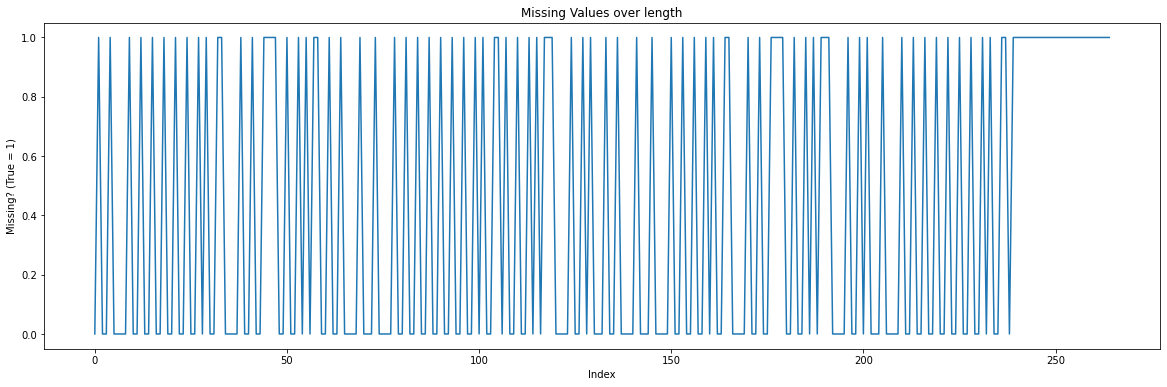

57.5187969924812% of data is present. 42.4812030075188% of data is missing.


In [4]:
# ------------------------- LOOK FOR MISSING MONTHS ------------------------- #

PltMissing( N = 20, data_set = SP500, verb = True, ext = 'prepro' )


At this point we can't really impute missing months, we'll have to take an average between the missing points within our complete dataset. This system took me quite a while to design correctly. Basically it splits the SP500 at the index where a date is missing, then it creates a new row that represents the average between the top and bottom of the split. This effectively means that larger gaps of missing values will be smoothed over by curved averages instead of being replaced with dataset wide averages or with flat averages, which would destroy the time series.

In [5]:
# THIS CAN ONLY BE RUN ONE TIME! OTHERWISE IT WILL WRECK THE DATA

# Callout entry length
print('SP500 Start Entries: {}'.format(SP500.describe().iloc[0][0]))

# ---------- LOOK FOR MISSING MONTHS ---------- #

# Set start date
today = datetime.date(2019, 3, 16)
today = today.replace(day = 1)
today -= relativedelta( years = N )
today += relativedelta(months = 1)

# Set end date
edate = datetime.date.today()

# ---------- GET FULL RANGE ---------- #

# Setup variables
DateRange = []
current = today

while current <= edate:
    DateRange.append(current)
    current += relativedelta(months=1)

# ---------- FIND WHEN MONTHS DON'T MATCH ---------- #

# Preallocate
Missing = []

# Cycle through every index
for i in range(len(DateRange) - 1):

    # Capture the date text
    d = DateRange[i].strftime('%Y-%m-%d')

    # Convert daterange into string array
    DateRange[i] = DateRange[i].strftime('%Y-%m-%d')

    # If the date exists in the larger set, take its values
    if d not in SP500.index:
        Missing.append(d)

# ---------- IMPUTE ---------- #
        
# Iterate and add columns as np.nan
for i in range(len(DateRange) - 1):
    
    # Test for state
    if DateRange[i] in Missing:
        
        # Split dataframes
        top = SP500.iloc[0 : i]
        bottom = SP500.iloc[i : len(SP500)]
        
        # If there are no previous elements
        if not top.size > 0:
            top = pd.DataFrame(data = SP500.iloc[0 : 1].values, index = [DateRange[i]], columns = SP500.columns.values)
            
        # If there are no future elements
        if not bottom.size > 0:
            bottom = pd.DataFrame(data = SP500.iloc[len(SP500) - 1 : len(SP500)].values, index = [DateRange[i]], columns = SP500.columns.values)

        # Iterate through columns to find averages
        ave_val = []
        for j in range(0, len(SP500.columns)):
            temp = round((top.iloc[len(top) - 1].values[j] + bottom.iloc[0].values[j]) /2, 2)
            ave_val.append(temp)

        # Save average to dataframe
        ave = pd.DataFrame([ave_val], index = [DateRange[i]], columns = SP500.columns.values)

        # Rezip dataframes together
        frames = [ top, ave, bottom ]
        SP500 = pd.concat(frames)

# Callout entry length
print('SP500 Stop Entries: {}'.format(SP500.describe().iloc[0][0]))

SP500 Start Entries: 153.0
SP500 Stop Entries: 266.0


<Figure size 432x288 with 0 Axes>

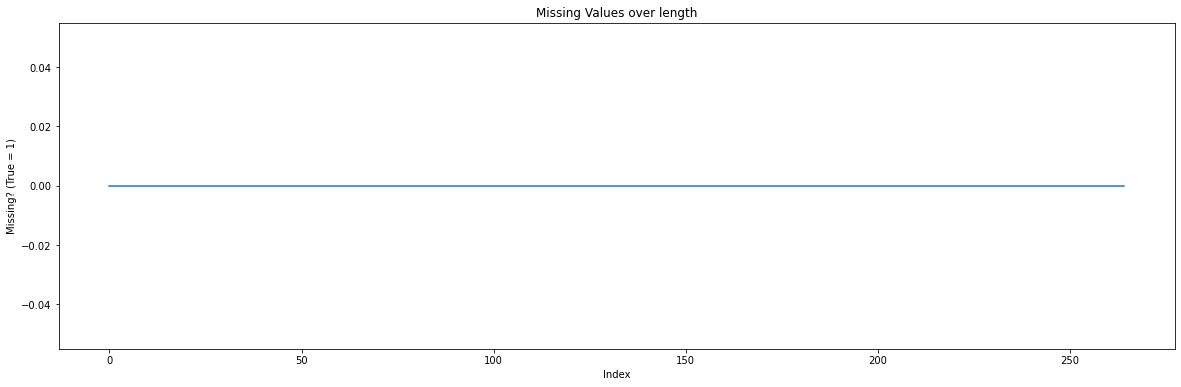

100.0% of data is present. 0.0% of data is missing.


In [6]:
# ------------------------- LOOK FOR MISSING MONTHS ------------------------- #

PltMissing( N = 20, data_set = SP500, verb = True, ext = 'postpro'  )

In [7]:
# ------------------------- REORDER AND CLEAN ------------------------- #

# Sort by index again
SP500.sort_index(inplace=True)

# Drop first duplicate index
SP500 = SP500.iloc[1:]
SP500.head(6)

,ADJ PRICE,PE RATIO,DIVIDEND YIELD,EYTY RATIO
1999-05-01,2117.51,33.12,1.25,0.550000
1999-06-01,2107.78,32.24,1.23,0.536332
1999-07-01,2194.32,32.88,1.24,0.519658
1999-08-01,2136.93,31.44,1.25,0.540000
1999-09-01,2079.53,29.99,1.25,0.555927
1999-10-01,2047.22,28.66,1.26,0.581667


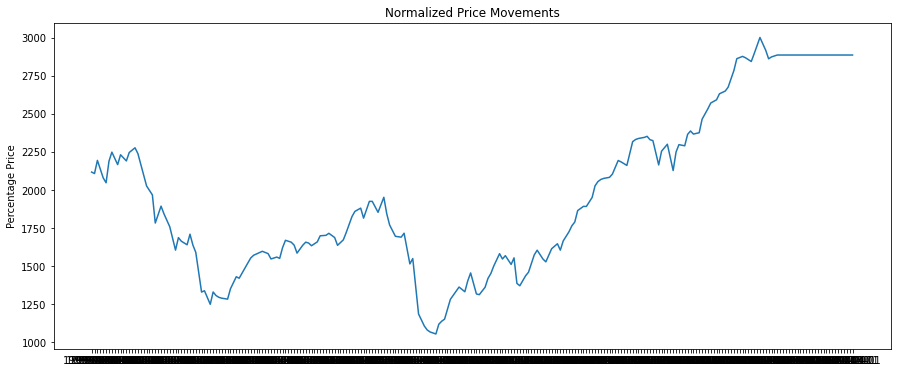

In [8]:
# ------------------------- PLOT SP500 ADJ CLOSE ------------------------- #

fig1 = plt.figure(figsize = (15, 6))
plt.plot(SP500.index.values, SP500['ADJ PRICE'])
plt.title('Normalized Price Movements')
plt.ylabel('Percentage Price')
plt.show()

I compared this graph with the Yahoo Finance SP500 trends and it illustrates the same trends and minor details.

## <a name="EXPORT"></a> [Export Data](#TOC)
---

While we could have this function called prior to LSTM analysis, this would be an incredibly inefficient approach to take. Rather, I will schedule this function to run once every week or so and update a CSV file which can be pulled and analyzed when ever the user requests an analysis.


In [9]:
# ------------------------- EXPORT DATA AS CSV ------------------------- #

# Round out EYTY ratio
SP500[['EYTY RATIO']] = SP500[['EYTY RATIO']].round(3)

# Export to CSV
SP500.to_csv(path_data / "SP500.csv", index = True)


## <a name="SPARE"></a> [Spare Model](#TOC)
---

The imputing process was incredibly complex. In order to develop it, I designed a representative model and programmed the algorithm generally so that it could be applied to the SP500 dataframe. In case I need to debug this in the future, I have left this model below for future study.


In [10]:
# ------------------------- SIMPLE IMPUTING MODEL ------------------------- #

# Create hypothetical dataframe
data1 = list(range(0, 10))
data2 = list(range(5, 15))
data = { 'One' : data1, 'Two' : data2}
df = pd.DataFrame(data)

# Remove some entries
df = df.drop(df.index[[1, 3]])

# Iterate and add columns as np.nan
for i in range(0, 10):
    # If the value is there, pass
    if i == df.index.values[i]:
            pass
    else:
        # Split dataframes
        top = df.iloc[0 : i]
        bottom = df.iloc[i : len(df)]

        # Iterate through columns to find averages
        ave_val = []
        for j in range(0, len(df.columns)):
            temp = (top.iloc[len(top)-1].values[j] + bottom.iloc[0].values[j]) /2
            ave_val.append(temp)

        # Save average to dataframe
        ave = pd.DataFrame([ave_val], index = [i], columns = df.columns.values)

        # Rezip dataframes together
        frames = [ top, ave, bottom ]
        df = pd.concat(frames)

# Print results
df

,One,Two
0,0.0,5.0
1,1.0,6.0
2,2.0,7.0
3,3.0,8.0
4,4.0,9.0
5,5.0,10.0
6,6.0,11.0
7,7.0,12.0
8,8.0,13.0
9,9.0,14.0
